In [1]:
import tensorflow as tf 
import os 
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.regularizers import l1
from keras.layers.core import Activation, Dense
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from scipy.stats import gaussian_kde

In [2]:
# Avoid OOM errors by setting GPU Memory Comsumption Growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
direct_p = ('/Users/abelcouto/Documents/Dissertation/sample/images')

print(os.listdir(direct_p))

['.DS_Store', 'Findings', 'No_Findings']


In [4]:
#Get data from directory, pipeline

data_pipe = tf.keras.utils.image_dataset_from_directory('images', image_size=(1024, 1024), batch_size=65,class_names = ['Findings', 'No_Findings'])

Found 5606 files belonging to 2 classes.
Metal device set to: Apple M1 Pro


2022-11-11 14:37:55.274677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-11 14:37:55.274801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:

data_iterator = data_pipe.as_numpy_iterator()

print (data_iterator)

In [6]:
batch = data_iterator.next()

print((batch[0].shape))

2022-11-11 14:37:55.353232: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(65, 1024, 1024, 3)


In [7]:
#Get image labels
print(batch[1])

[1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0
 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0]


In [8]:

data_pipe = data_pipe.map(lambda x,y: (x/255, y))

In [9]:
scaled_iterator = data_pipe.as_numpy_iterator()

In [10]:
batch= scaled_iterator.next()
print(batch[0].max())

1.0


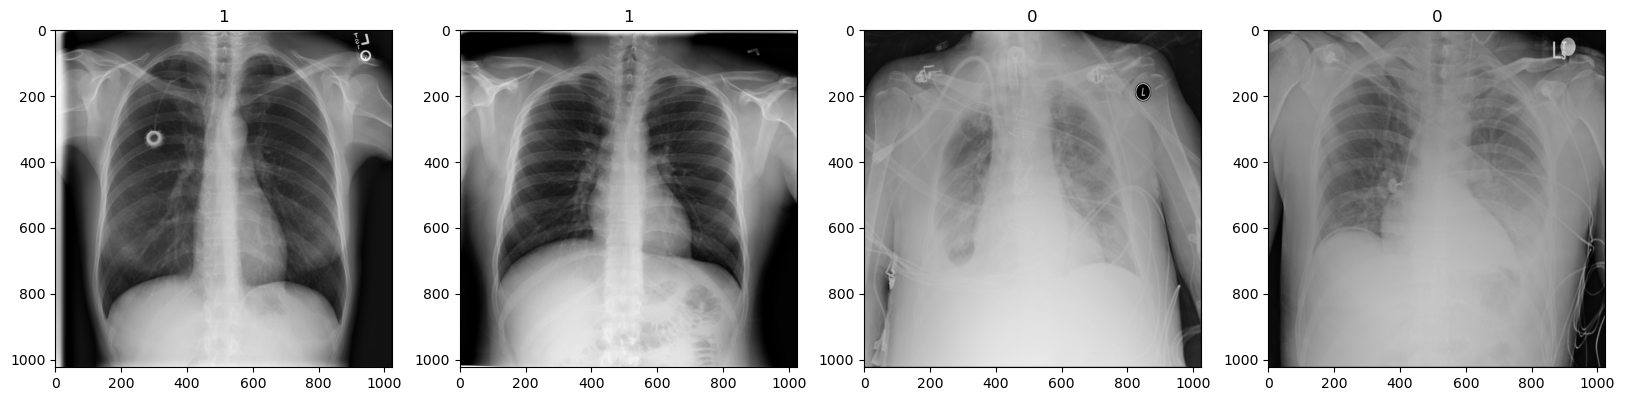

In [11]:

fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])



In [12]:
print(len(data_pipe))

87


In [13]:
# Set parameters to divide our data sample
train_s = int(len(data_pipe)*.7)
val_s = int(len(data_pipe)*.2)+1
test_s = int(len(data_pipe)*.1)+1

In [14]:
print(test_s+train_s+val_s)

87


In [15]:
#Get data for train, val, test

train = data_pipe.take(train_s)
val = data_pipe.skip(train_s).take(val_s)
test = data_pipe.skip(train_s + val_s).take(test_s)

In [16]:
# Create Model 

model = Sequential()

In [17]:
model.add(Conv2D(16, (3,3),(2, 2), activation='relu', input_shape=(1024,1024,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(32, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(16, (3,3), (2, 2), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(256, activation ='linear', activity_regularizer=l1(0.001)))
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))

In [18]:
num_epochs = 25
num_train_steps = train_s * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=0.01,
    end_learning_rate=0.00001,
    decay_steps=num_train_steps
)



opt = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
model.compile(optimizer = opt,loss= tf.losses.BinaryCrossentropy(),metrics= ['accuracy',tf.keras.metrics.Precision(),
                                                                     tf.keras.metrics.Recall()
                                                                     ])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 511, 511, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 511, 511, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 255, 255, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 127, 127, 32)     1

In [20]:
logdir = 'logs'

In [21]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [22]:
mu=0.0
std = 0.1
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 


In [ ]:
hist = model.fit(train, epochs = 25, validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/25


2022-11-11 14:44:10.490079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 1.0255 - accuracy: 0.5510 - precision: 0.5818 - recall: 0.6080

2022-11-11 14:45:16.933745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 96s 1s/step - loss: 1.0255 - accuracy: 0.5510 - precision: 0.5818 - recall: 0.6080 - val_loss: 1.9056 - val_accuracy: 0.5513 - val_precision: 0.5518 - val_recall: 0.9985
Epoch 2/25
60/60 [==============================] - 137s 2s/step - loss: 0.7863 - accuracy: 0.5756 - precision: 0.5937 - recall: 0.6867 - val_loss: 0.7335 - val_accuracy: 0.6188 - val_precision: 0.6474 - val_recall: 0.6413
Epoch 3/25
60/60 [==============================] - 95s 2s/step - loss: 0.7333 - accuracy: 0.5921 - precision: 0.6083 - recall: 0.7108 - val_loss: 0.7097 - val_accuracy: 0.5932 - val_precision: 0.6046 - val_recall: 0.6822
Epoch 4/25
60/60 [==============================] - 91s 1s/step - loss: 0.7015 - accuracy: 0.6179 - precision: 0.6237 - recall: 0.7524 - val_loss: 0.6809 - val_accuracy: 0.6120 - val_precision: 0.5972 - val_recall: 0.8655
Epoch 5/25
60/60 [==============================] - 98s 2s/step - loss: 0.6882 - accuracy: 0.6085 - precision: 0.6145 - re

2022-11-11 15:27:26.243083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 48 of 520
2022-11-11 15:27:26.258217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 49 of 520
2022-11-11 15:27:26.258226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 50 of 520
2022-11-11 15:27:26.258229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 51 of 520
2022-11-11 15:27:26.258234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 52 of 520
2022-11-11 15:27:26.258239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 53 of 520
2022-11-11 15:27:26.258242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this 

2022-11-11 15:27:26.499569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 124 of 520
2022-11-11 15:27:26.499581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 125 of 520
2022-11-11 15:27:26.499587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 126 of 520
2022-11-11 15:27:26.499590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 127 of 520
2022-11-11 15:27:26.499595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 128 of 520
2022-11-11 15:27:26.504128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 129 of 520
2022-11-11 15:27:26.515789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer 

60/60 [==============================] - 3672s 62s/step - loss: 0.6667 - accuracy: 0.6262 - precision: 0.6372 - recall: 0.7221 - val_loss: 0.6660 - val_accuracy: 0.6205 - val_precision: 0.6192 - val_recall: 0.7811
Epoch 10/25


In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color= 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color= 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc= 'upper left')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color= 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color= 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc= 'upper left')
plt.show()

In [ ]:
hist.history

In [ ]:
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    x,y = batch
    yhat = model.predict(x)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {prec.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')


In [ ]:
F05 = (1.25 * 0.6291559934616089 * 0.8145695328712463) / (0.25 * 0.6291559934616089 + 0.8145695328712463)

In [ ]:
print(F05)